# Trabajo final del Diplomado en AI & DL Universidad Nacional de Colombia
## Clasificación de cambios de coberturas vegetales en imágenes de satélite Sentinel-2 en los humedales de Bogotá 
### Fecha: Mayo de 2021
### Autores: Samuel Mesa, Wilgen Correa

### Cargar librerias

In [1]:
import datetime
import os, glob
import numpy as np
import seaborn as sns
import geopandas as gpd
import pandas as pd
import imageio
from pyspatialml import Raster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.impute import SimpleImputer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import CSVLogger, RemoteMonitor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import earthpy.plot as ep
import earthpy.spatial as es

### Realizar el cargue de imágenes y las áreas de enetrenamiento

Bandas a seleccionar de la imagen de entrada de SENTINEL-2, con remuestreo a 10 m de resolución espacial

1. B2 (Blue)
2. B3 (Green)
3. B4 (Red)
4. B5 (Veg. red edge)
5. B6 (Veg. red edge)
6. B7 (Veg. red edge)
7. B8 (NIR)
8. B8A (Narrow NIR)
9. B11 (SWIR)
10. B12 (SWIR)

La estructura de directorios es el siguiente.

* [nombre_proyecto]
  * shapes: shapes de aoi y capas de superposición
  * models: Almacena el modelo
  * sources: imágenes satelitales de entrada
  * results: resultados de las clasificación
  * logs: logs del entrenamiento
  * figures: imágenes y figuras 

In [25]:
path_project = "./tunjo/"
path_sources = os.path.join(path_project, "sources")
path_shapes = os.path.join(path_project, "shapes")
path_results = os.path.join(path_project, "results")
path_logs = os.path.join(path_project, "logs")
path_figures = os.path.join(path_project, "figures")
path_models = os.path.join(path_project, "models")
list_paths = [path_results, path_figures, path_models, path_logs]

# Crear directorios temporales

for path in list_paths:  
    try:
        os.mkdir(path)
    except FileExistsError:
        print("Directorio ya existe: ", os.path.basename(path))

# Defina la imagen de entrada 
img_train = '20210309T152639_20210309T152638_T18NWL.tif'
img_file = os.path.join(path_sources, img_train) 
aoi_file = os.path.join(path_shapes, 'aoi.geojson') # Formato geográfico
manzana_file = os.path.join(path_shapes, 'manzana.geojson') # Formato geográfico
img_name = img_train.split('_')[0] 

# Cargar la imagen como un objeto Raster Dataframe y el shape de aoi como Geodaataframe
stack = Raster(img_file)
training = gpd.read_file(aoi_file)
manzana = gpd.read_file(manzana_file)

bandsio = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
bandsio_names = ['B2 (Blue)', 'B3 (Green)', 'B4 (Red)', 'B5 (Veg. red edge)', 
               'B6 (Veg. red edge)', 'B7 (Veg. red edge)', 'B8 (NIR)', 
               'B8A (Narrow NIR)', 'B11 (SWIR)', 'B12 (SWIR)']

# Mapea los nombres de bandas de entrada
[stack.rename({name: bandsio[idx]}, in_place=True) for idx, name in enumerate(stack.names)]
extent = es.rio.plot.plotting_extent(stack)

Directorio ya existe:  results
Directorio ya existe:  figures
Directorio ya existe:  models


## Se define la selección de bandas de entrenamineto y salida para todo el proceso

In [4]:
bandsout = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
bandsout_names = ['B2 (Blue)', 'B3 (Green)', 'B4 (Red)', 'B5 (Veg. red edge)', 
               'B6 (Veg. red edge)', 'B7 (Veg. red edge)', 'B8 (NIR)', 
               'B8A (Narrow NIR)', 'B11 (SWIR)', 'B12 (SWIR)']

## Anáisis exploratorio de datos

Despliegue de imágenes y análisis exploratorio

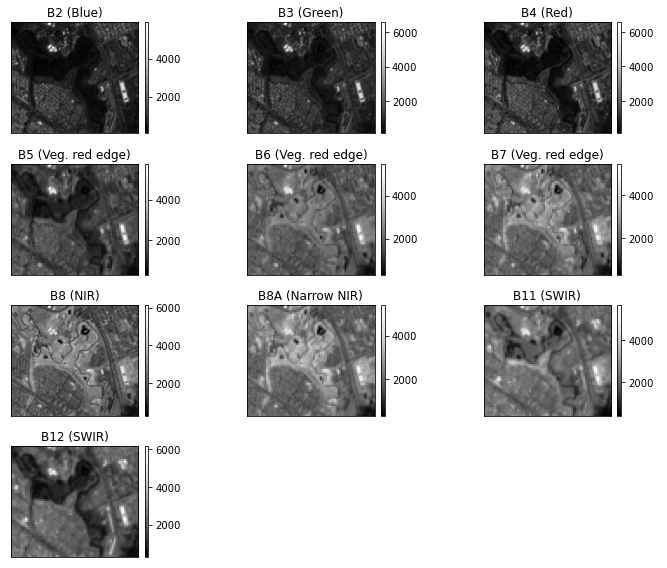

array([[<AxesSubplot:title={'center':'B2 (Blue)'}>,
        <AxesSubplot:title={'center':'B3 (Green)'}>,
        <AxesSubplot:title={'center':'B4 (Red)'}>],
       [<AxesSubplot:title={'center':'B5 (Veg. red edge)'}>,
        <AxesSubplot:title={'center':'B6 (Veg. red edge)'}>,
        <AxesSubplot:title={'center':'B7 (Veg. red edge)'}>],
       [<AxesSubplot:title={'center':'B8 (NIR)'}>,
        <AxesSubplot:title={'center':'B8A (Narrow NIR)'}>,
        <AxesSubplot:title={'center':'B11 (SWIR)'}>],
       [<AxesSubplot:title={'center':'B12 (SWIR)'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

In [5]:
# Despliegue los canales  imágenes
ep.plot_bands(stack[bandsout].read(), title=bandsout_names, figsize=(10, 8))

(<Figure size 864x864 with 10 Axes>,
 array([[<AxesSubplot:title={'center':'B2 (Blue)'}, ylabel='Reflectancia'>,
         <AxesSubplot:title={'center':'B3 (Green)'}, ylabel='Reflectancia'>],
        [<AxesSubplot:title={'center':'B4 (Red)'}, ylabel='Reflectancia'>,
         <AxesSubplot:title={'center':'B5 (Veg. red edge)'}, ylabel='Reflectancia'>],
        [<AxesSubplot:title={'center':'B6 (Veg. red edge)'}, ylabel='Reflectancia'>,
         <AxesSubplot:title={'center':'B7 (Veg. red edge)'}, ylabel='Reflectancia'>],
        [<AxesSubplot:title={'center':'B8 (NIR)'}, ylabel='Reflectancia'>,
         <AxesSubplot:title={'center':'B8A (Narrow NIR)'}, ylabel='Reflectancia'>],
        [<AxesSubplot:title={'center':'B11 (SWIR)'}, ylabel='Reflectancia'>,
         <AxesSubplot:title={'center':'B12 (SWIR)'}, ylabel='Reflectancia'>]],
       dtype=object))

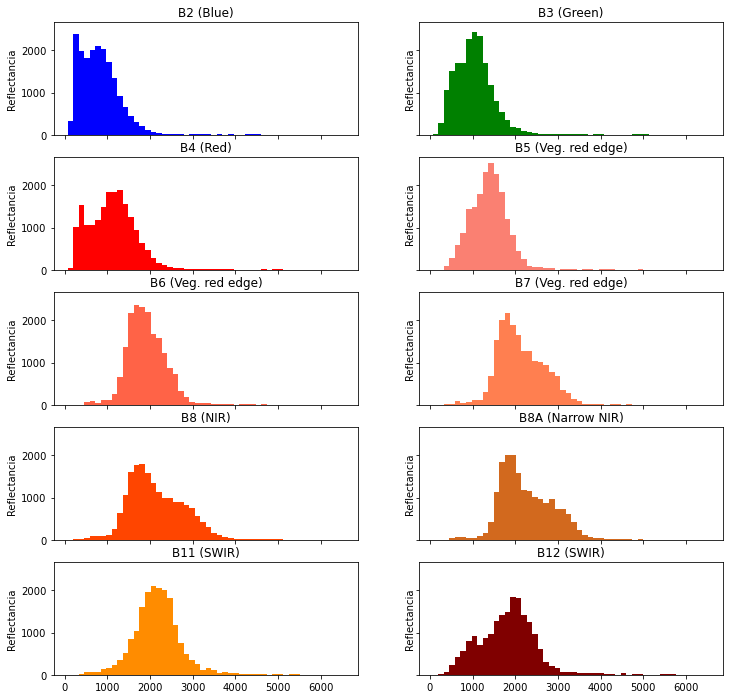

In [6]:
# Histogramas por bandas

colors_list = ["Blue", "Green", "Red", "Salmon", "Tomato", "Coral", "Orangered",
               "Chocolate","Darkorange","Maroon"]

ep.hist(stack[bandsout].read(), colors=colors_list, title=bandsout_names, 
        ylabel='Reflectancia', bins=50, cols=2)

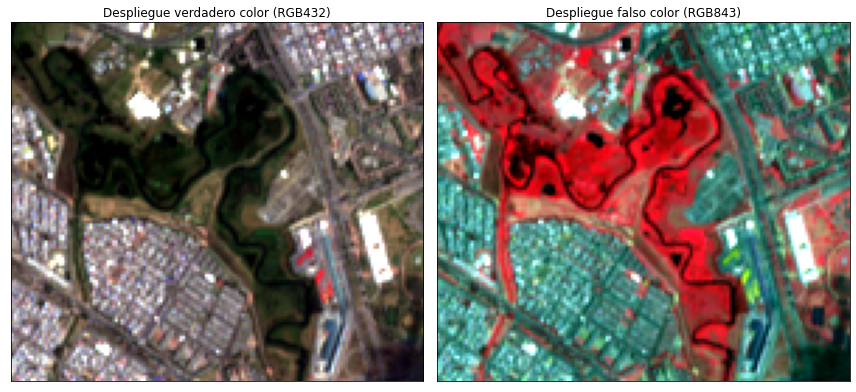

In [7]:
# Despliegue composición de color

rgb432 = stack[['B4','B3', 'B2']].read()
rgb843 = stack[['B8','B4', 'B3']].read()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ep.plot_rgb(rgb432, ax=ax1, title='Despliegue verdadero color (RGB432)', stretch=True)
ep.plot_rgb(rgb843, ax=ax2, title='Despliegue falso color (RGB843)', stretch=True)
plt.tight_layout()
plt.show()

Despliegue de las áreas de entrenamiento

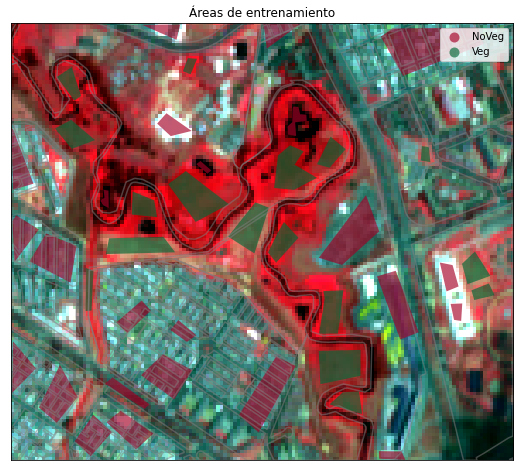

In [8]:
fig, ax = plt.subplots(figsize=(9, 9))
ep.plot_rgb(rgb843, ax=ax, stretch=True, extent=extent)
manzana.boundary.plot(ax=ax, color='grey', alpha=0.5,)
training.plot(column="label", cmap='RdYlGn', ax=ax, legend=True,  alpha=0.65, categorical=True)
ax.axis('on')
plt.title('Áreas de entrenamiento')
plt.show()

In [9]:
# Convertir los pixeles a un dataframe de pandas

df = stack[bandsout].to_pandas()
df.head()

x         y     B2     B3     B4      B5      B6      B7  \
0  594300.000000  506180.0  306.0  552.0  521.0   764.0  1610.0  2268.0   
1  594310.068493  506180.0  248.0  354.0  308.0   764.0  1610.0  2268.0   
2  594320.136986  506180.0  290.0  575.0  449.0   973.0  2427.0  2693.0   
3  594330.205479  506180.0  334.0  666.0  514.0   973.0  2427.0  2693.0   
4  594340.273973  506180.0  363.0  743.0  607.0  1132.0  2492.0  2963.0   

       B8     B8A     B11     B12  
0  2382.0  2557.0  1628.0  1033.0  
1  1790.0  2557.0  1628.0  1033.0  
2  2808.0  2838.0  1856.0  1064.0  
3  3164.0  2838.0  1856.0  1064.0  
4  2900.0  3366.0  2057.0  1234.0

In [10]:
print('Las columnas son: ', df.columns)
print('El tamaño´ del dataframe: ', df.shape)
print(df[bandsout].describe().T)

Las columnas son:  Index(['x', 'y', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11',
       'B12'],
      dtype='object')
El tamaño´ del dataframe:  (18816, 12)
       count         mean         std    min     25%     50%      75%     max
B2   18816.0   836.277583  530.597252   64.0   454.0   769.0  1080.00  5908.0
B3   18816.0  1066.075999  532.072826  133.0   722.0  1017.0  1284.00  6556.0
B4   18816.0  1138.359800  609.381740  114.0   714.0  1116.0  1456.00  6544.0
B5   18816.0  1406.380102  503.829649  308.0  1094.0  1391.0  1648.00  5772.0
B6   18816.0  1920.350872  486.753114  319.0  1608.0  1870.5  2184.25  5491.0
B7   18816.0  2132.852572  568.216038  326.0  1734.0  2036.0  2496.25  5425.0
B8   18816.0  2153.274979  655.596387  273.0  1678.0  2034.0  2602.00  6136.0
B8A  18816.0  2261.102891  617.403156  307.0  1804.0  2126.0  2699.00  5409.0
B11  18816.0  2173.782100  563.845698  392.0  1848.0  2155.5  2457.00  5675.0
B12  18816.0  1824.713010  675.126151  277.0  1379.0

In [11]:
# Correlacción de las bandas

correlation_data = df.iloc[:,2:].corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)  

In [12]:
# Extraer información de las bandas con la áreas de entrenamiento

df_shape = stack[bandsout].extract_vector(training)

df_shape = df_shape.merge(
    right=training.loc[:, ["label", "id"]],
    left_on="geometry_idx",
    right_on="index",
    right_index=True
)

df_shape = df_shape.dropna()

In [13]:
# Descripcion de los datos para las areas de entrenamineto

print('Total canales espectrales: ',  df_shape.columns)
print('Tamaño de entrenamiento: ', df_shape.shape)
print(df[bandsout].describe().T)

Total canales espectrales:  Index(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
       'geometry', 'label', 'id'],
      dtype='object')
Tamaño de entrenamiento:  (3370, 13)
       count         mean         std    min     25%     50%      75%     max
B2   18816.0   836.277583  530.597252   64.0   454.0   769.0  1080.00  5908.0
B3   18816.0  1066.075999  532.072826  133.0   722.0  1017.0  1284.00  6556.0
B4   18816.0  1138.359800  609.381740  114.0   714.0  1116.0  1456.00  6544.0
B5   18816.0  1406.380102  503.829649  308.0  1094.0  1391.0  1648.00  5772.0
B6   18816.0  1920.350872  486.753114  319.0  1608.0  1870.5  2184.25  5491.0
B7   18816.0  2132.852572  568.216038  326.0  1734.0  2036.0  2496.25  5425.0
B8   18816.0  2153.274979  655.596387  273.0  1678.0  2034.0  2602.00  6136.0
B8A  18816.0  2261.102891  617.403156  307.0  1804.0  2126.0  2699.00  5409.0
B11  18816.0  2173.782100  563.845698  392.0  1848.0  2155.5  2457.00  5675.0
B12  18816.0  1824.713010  6

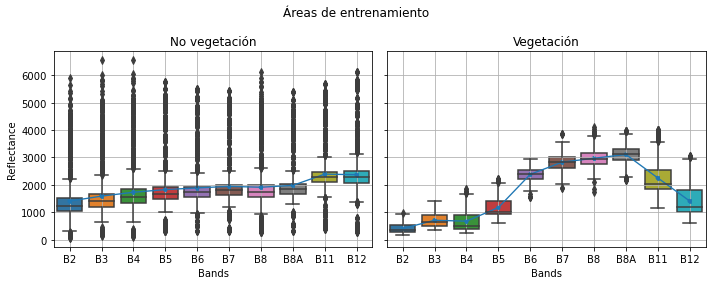

In [15]:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)
plt.suptitle("Áreas de entrenamiento")
axes[0].set_title('No vegetación')
axes[1].set_title('Vegetación')
axes[0].set_xlabel('Bands')
axes[0].set_ylabel('Reflectance')
axes[1].set_xlabel('Bands')
sns.pointplot(data=df_shape[df_shape['id'] == 0][bandsout], ax=axes[0], 
              scale=0.5, estimator=np.mean)
sns.boxplot(data=df_shape[df_shape['id'] == 0][bandsout], ax=axes[0])
sns.pointplot(data=df_shape[df_shape['id'] == 1][bandsout], ax=axes[1], 
              scale=0.5, estimator=np.mean)
sns.boxplot(data=df_shape[df_shape['id'] == 1][bandsout], ax=axes[1])
axes[0].grid()
axes[1].grid()
plt.tight_layout()
fig.show()

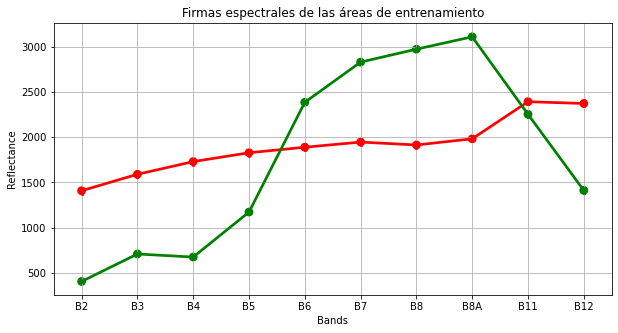

In [16]:
fig, ax = plt.subplots(figsize=(10,5), sharey=True, sharex=True)
ax.set_title('Firmas espectrales de las áreas de entrenamiento')
ax.set_xlabel('Bands')
ax.set_ylabel('Reflectance')
sns.pointplot(data=df_shape[df_shape['id'] == 0][bandsout], ax=ax, 
              scale=1, estimator=np.mean, color='red')
sns.pointplot(data=df_shape[df_shape['id'] == 1][bandsout], ax=ax, 
              scale=1, estimator=np.mean, color='green')
ax.grid()
fig.show()

## Entrenamineto de la red neuronal

Dividir las areas de entrenamineto y validación 

In [17]:
#bands = ['B2', 'B3', 'B4', 'B7']

X = df_shape[bandsout].values
y = df_shape["id"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [26]:
# Logs y callbacks para el entrenamiento

timename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_csv = os.path.join(path_logs, f"log_{img_name}-{timename}.csv")
model_h5 = os.path.join(path_models, f"model_{img_name}-{timename}.h5")
imgkeras_classification = os.path.join(path_results, f"classkeras_{img_name}-{timename}.tif")
imgkeras_probability = os.path.join(path_results, f"probkeras_{img_name}-{timename}.tif")
imgkneig_classification = os.path.join(path_results, f"classkneig_{img_name}-{timename}.tif")
imgkneig_probability = os.path.join(path_results, f"probkneig_{img_name}-{timename}.tif")
fig_model = os.path.join(path_figures, f"train_{img_name}-{timename}.png")
movie_classkeras = os.path.join(path_figures, f"movie_classkeras_{timename}.gif")

call_save_model = tf.keras.callbacks.ModelCheckpoint(
    model_h5, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None
)

call_tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True,
    update_freq='epoch', profile_batch=2, embeddings_freq=0,
    embeddings_metadata=True
)

call_csv = CSVLogger(log_csv, separator=",", append=False)

call_remote = RemoteMonitor(
    root='http://localhost:9000',
)

In [27]:
# Crear la funcion model de keras

def create_keras_model(layer1_units, layer2_units, dropout_rate, l2_regularization):
    model = Sequential([
        ## Adiciona capas una por una
        Dense(units=layer1_units, activation='relu', input_shape=(len(bandsout),)),
        # Adding dropout to prevent overfitting (regularización)
        Dropout(dropout_rate), # 10% out in each epoc
        Dense(units=layer2_units, activation='relu'),
        # Adding dropout to prevent overfitting (regularización)
        #model.add(Dropout(0.1))
        Dense(units=1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

In [28]:
# Realizar el entrenamiento

classifier_keras = KerasClassifier(
    build_fn=create_keras_model, 
    batch_size=32, 
    layer1_units=16,
    layer2_units=32,
    dropout_rate=0.025,
    l2_regularization=0,
    epochs=25, 
    shuffle=True, 
    validation_split=0.2,
    callbacks=[call_save_model, call_tensorboard, call_csv, call_remote],
    verbose=True
)

pipeline_keras = Pipeline([
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler()), 
    ('model', classifier_keras)
])

pipeline_keras.fit(X=X_train, y=y_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                176       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
68/68 [==============================] - 2s 19ms/step - loss: 0.6289 - accuracy: 0.6550 - val_loss: 0.2573 - val_accuracy: 0.9907
Epoch 2/25
68/68 [==============================] - 1s 9ms/step - loss: 0.1777 - accuracy: 0.9931 - val_loss

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb85c2b3850>)])

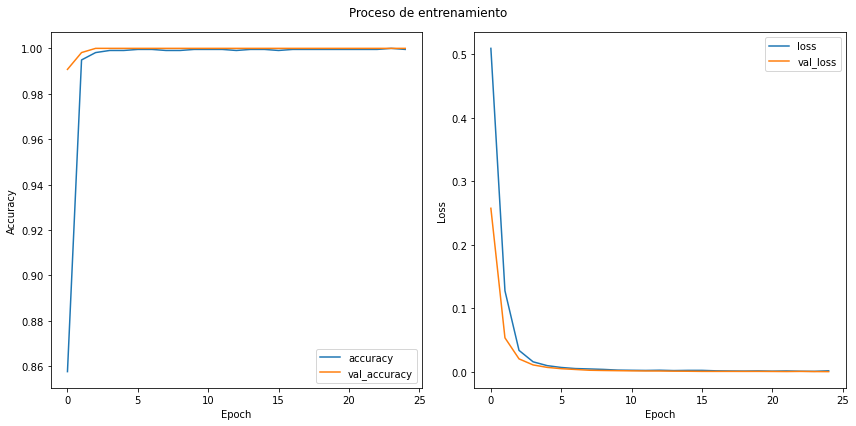

In [29]:
# Log CSV

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Proceso de entrenamiento')
history = pd.read_csv(log_csv)
history[['accuracy', 'val_accuracy']].plot(ylabel='Accuracy', ax=ax1, xlabel='Epoch')
history[['loss', 'val_loss']].plot(ylabel='Loss', ax=ax2, xlabel='Epoch')
plt.tight_layout()
plt.show()

In [30]:
classifier_neigh = KNeighborsClassifier(n_neighbors=3)
classifier_neigh.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=3)

## Predicciones

Predicciones en la imagen

In [31]:
result_keras = stack[bandsout].predict(estimator=pipeline_keras, dtype='uint8', nodata=255)
result_keras_probs = stack[bandsout].predict_proba(estimator=pipeline_keras)

result_neigh = stack[bandsout].predict(estimator=classifier_neigh, dtype='uint8', nodata=255)
result_neigh_probs = stack[bandsout].predict_proba(estimator=classifier_neigh)

588/588 [==============================] - 3s 6ms/step


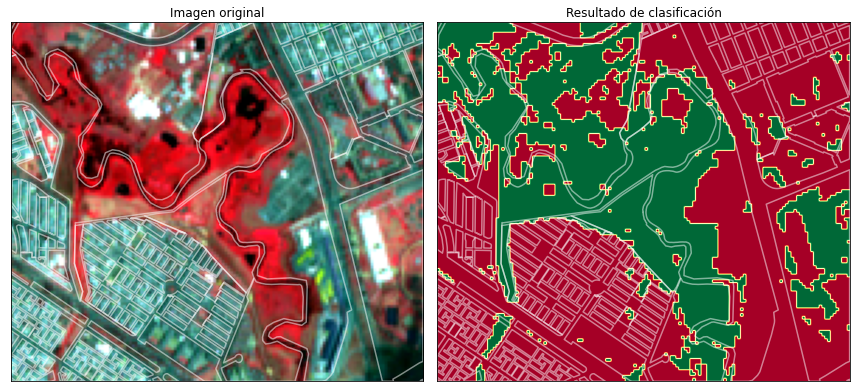

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

ep.plot_rgb(rgb843, extent=extent, ax=ax1, stretch=True, title="Imagen original")
manzana.boundary.plot(ax=ax1, color='white', alpha=0.5,)

ep.plot_bands(result_keras.read(), extent=extent, cmap="RdYlGn", cbar=False, 
              title='Resultado de clasificación', ax=ax2)
manzana.boundary.plot(ax=ax2, color='white', alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
# Almacenamiento de los resultados de la imagen 

result_keras.write(imgkeras_classification, nodata=255)
result_keras_probs.write(imgkeras_probability, nodata=255)

result_neigh.write(imgkneig_classification, nodata=255)
result_neigh_probs.write(imgkneig_probability, nodata=255)

## Evaluaciones 

Métricas de evaluación de la clasificación

In [34]:
# Calcular la evaluación de exactitud temática

def calculate_binary_class_scores(y_true, y_pred):
   accuracy = accuracy_score(y_true, y_pred.astype('int64'))
   precision = precision_score(y_true, y_pred.astype('int64'))
   recall = recall_score(y_true, y_pred.astype('int64'))
   return accuracy, precision, recall

22/22 [==============================] - 1s 10ms/step
Keras Test Data Accuracy (%) =  100.0
Keras Test Data Precision (%) =  100.0
Keras Test Data Recall (%) =  100.0
Keras accuracy is 100.0%


<AxesSubplot:>

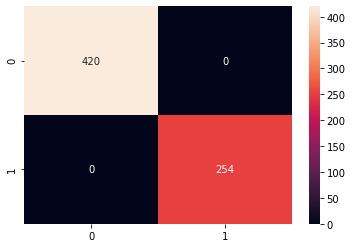

In [35]:
# Evaluación Test clasificación de Keras

y_pred = pipeline_keras.predict(X_test)
test_accuracy_score2, test_precision_score2, test_recall_score2 = calculate_binary_class_scores(y_test, y_pred)

print('Keras Test Data Accuracy (%) = ', round(test_accuracy_score2*100,2))
print('Keras Test Data Precision (%) = ', round(test_precision_score2*100,2))
print('Keras Test Data Recall (%) = ', round(test_recall_score2*100,2))

cm = confusion_matrix(y_test, y_pred)
print("Keras accuracy is {}%".format(((cm[0][0] + cm[1][1])/y_test.shape[0])*100))
sns.heatmap(cm,annot=True, fmt='g')

KNeighbors Test Data Accuracy (%) =  100.0
KNeighbors Test Data Precision (%) =  100.0
KNeighbors Test Data Recall (%) =  100.0
KNeighbors Test accuracy is 100.0%


<AxesSubplot:>

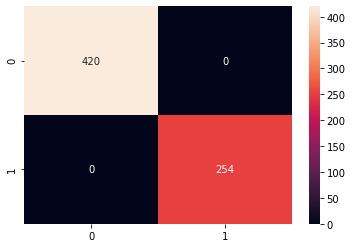

In [36]:
# Evaluación Test clasificación de KNeighbors

y_pred = classifier_neigh.predict(X_test)
test_accuracy_score2, test_precision_score2, test_recall_score2 = calculate_binary_class_scores(y_test, y_pred)

print('KNeighbors Test Data Accuracy (%) = ', round(test_accuracy_score2*100,2))
print('KNeighbors Test Data Precision (%) = ', round(test_precision_score2*100,2))
print('KNeighbors Test Data Recall (%) = ', round(test_recall_score2*100,2))

cm = confusion_matrix(y_test, y_pred)
print("KNeighbors Test accuracy is {}%".format(((cm[0][0] + cm[1][1])/y_test.shape[0])*100))
sns.heatmap(cm,annot=True, fmt='g')

85/85 [==============================] - 1s 9ms/step
Keras Train Data Accuracy (%) =  99.96
Keras Train Data Precision (%) =  100.0
Keras Train Data Recall (%) =  99.9
Keras Train accuracy is 99.96290801186943%


<AxesSubplot:>

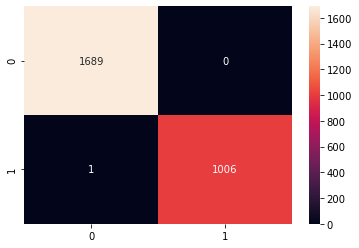

In [37]:
# Evaluación Train clasificación de calidad Keras

y_pred = pipeline_keras.predict(X_train)
train_accuracy_score2, train_precision_score2, train_recall_score2 = calculate_binary_class_scores(y_train, y_pred)

print('Keras Train Data Accuracy (%) = ', round(train_accuracy_score2*100,2))
print('Keras Train Data Precision (%) = ', round(train_precision_score2*100,2))
print('Keras Train Data Recall (%) = ', round(train_recall_score2*100,2))

cm = confusion_matrix(y_train, y_pred)
print("Keras Train accuracy is {}%".format(((cm[0][0] + cm[1][1])/y_train.shape[0])*100))
sns.heatmap(cm,annot=True, fmt='g')

KNeighbors Train Data Accuracy (%) =  99.96
KNeighbors Train Data Precision (%) =  99.9
KNeighbors Train Data Recall (%) =  100.0
KNeighbors Train accuracy is 99.96290801186943%


<AxesSubplot:>

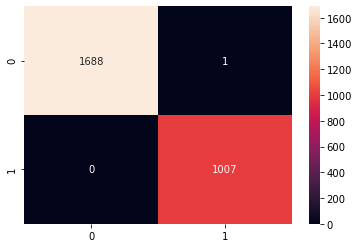

In [38]:
# Evaluación Train clasificación de calidad KNeighbirs

y_pred = classifier_neigh.predict(X_train)
train_accuracy_score2, train_precision_score2, train_recall_score2 = calculate_binary_class_scores(y_train, y_pred)

print('KNeighbors Train Data Accuracy (%) = ', round(train_accuracy_score2*100,2))
print('KNeighbors Train Data Precision (%) = ', round(train_precision_score2*100,2))
print('KNeighbors Train Data Recall (%) = ', round(train_recall_score2*100,2))

cm = confusion_matrix(y_train, y_pred)
print("KNeighbors Train accuracy is {}%".format(((cm[0][0] + cm[1][1])/y_train.shape[0])*100))
sns.heatmap(cm,annot=True, fmt='g')

## Implmenetación  

Implementación dle modelo

Para imágenes SENTINEL se recomiendan los siguientes índices de vegetación:

Normalized Difference Vegetation Index (NDVI)

$$NDVI = (B8 – B4) / (B8 + B4)$$

Green Normalized Difference Vegetation Index (GNDVI)

$$GNDVI = (B8 – B3) / (B8 + B3)$$

Enhanced Vegetation Index (EVI)

$$EVI = 2.5 * (B8 – B4) / ((B8 + 6 * B4 – 7.5 * B2) + 1))$$

Advanced Vegetation Index (AVI)

$$AVI = [B8 * (1 – B4)*(B8 – B4)]^(1/3)$$
        

In [39]:
ndvi_file = os.path.join(path_results, f"ndvi_{img_name}-{timename}.tif")
evi_file = os.path.join(path_results, f"evi_{img_name}-{timename}.tif")

ndvi = (stack.B8.read().astype(float) - stack.B4.read().astype(float))/(
    stack.B8.read().astype(float) + stack.B4.read().astype(float)
)

## Dado que los datos de reflectancia vienen reescalados por un factor de 10.000

evi = 2.5 * (stack.B8.read()*0.0001- stack.B4.read()*0.0001)/(
    (stack.B8.read()*0.0001 + 6 * (stack.B4.read()*0.0001) 
    -  7.5 * (stack.B4.read()*0.0001)) + 1
)

raster_ndvi = Raster(np.where(ndvi >= 0.3, 1, 0).astype('uint8'), 
                     transform=result_keras.transform, crs=result_keras.crs,
                     mode='w+', in_memory=False)

raster_evi = Raster(np.where(evi >= 0.3, 1, 0).astype('uint8'), 
                    transform=result_keras.transform, crs=result_keras.crs, 
                    mode='w+', in_memory=False)

raster_ndvi.write(ndvi_file)
raster_evi.write(evi_file)

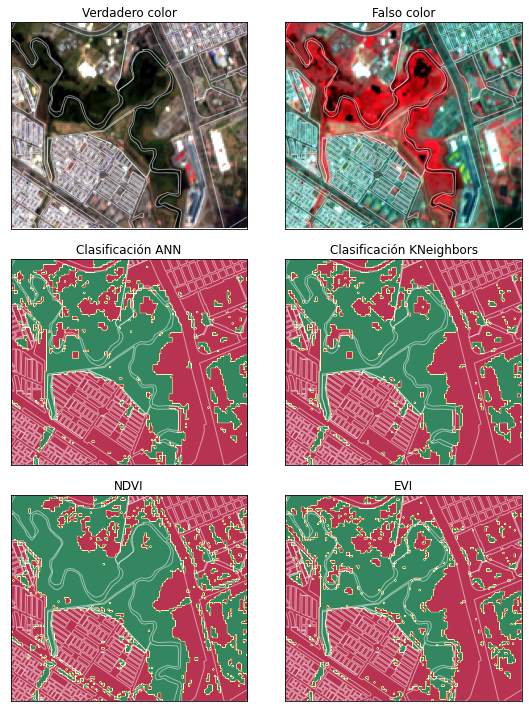

In [40]:
# Despliege de los resultados de clasificación y NDVI

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
# Plot verdadero color
ep.plot_rgb(rgb432, extent=extent, ax=axes[0,0], stretch=True, title='Verdadero color')
manzana.boundary.plot(ax=axes[0,0], color='white', alpha=0.5, linewidth=1)
# Plot falso color
ep.plot_rgb(rgb843, extent=extent, ax=axes[0,1], stretch=True, title='Falso color')
manzana.boundary.plot(ax=axes[0,1], color='white', alpha=0.5, linewidth=1)
# Plot Class Keras
ep.plot_bands(result_keras.read(), extent=extent, ax=axes[1,0], cmap='RdYlGn', 
              alpha=0.8, title="Clasificación ANN", cbar=False)
manzana.boundary.plot(ax=axes[1,0], color='white', alpha=0.5, linewidth=1)
# Plot class KNeigh
# Plot Class Keras
ep.plot_bands(result_neigh.read(), extent=extent, ax=axes[1,1], cmap='RdYlGn', 
              alpha=0.8, title="Clasificación KNeighbors", cbar=False)
manzana.boundary.plot(ax=axes[1,1], color='white', alpha=0.5, linewidth=1)
# Plot ndvi
ep.plot_bands(raster_ndvi.read(), extent=extent, ax=axes[2,0], cmap='RdYlGn', 
              alpha=0.8, title="NDVI", cbar=False)
manzana.boundary.plot(ax=axes[2,0], color='white', alpha=0.5, linewidth=1)
# Plot EVI
ep.plot_bands(raster_evi.read(), extent=extent, ax=axes[2,1], cmap='RdYlGn', 
              alpha=0.8, title="EVI", cbar=False)
manzana.boundary.plot(ax=axes[2,1], color='white', alpha=0.5, linewidth=1)
plt.tight_layout()
plt.show()

In [41]:
df_ndvi = raster_ndvi.extract_vector(training)
df_ndvi.rename(columns={df_ndvi.columns[0]: 'id'}, inplace=True)

df_evi = raster_evi.extract_vector(training)
df_evi.rename(columns={df_evi.columns[0]: 'id'}, inplace=True)

NDVI Test Data Accuracy (%) =  62.85
NDVI Test Data Precision (%) =  50.35
NDVI Test Data Recall (%) =  51.7
NDVI accuracy is 62.848664688427306%


<AxesSubplot:>

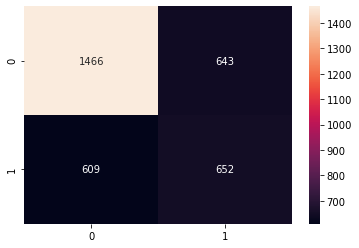

In [43]:
# Evaluación Test de NDVI 

train_accuracy_score2, train_precision_score2, train_recall_score2 = calculate_binary_class_scores(y, df_ndvi['id'].values)

print('NDVI Test Data Accuracy (%) = ', round(train_accuracy_score2*100,2))
print('NDVI Test Data Precision (%) = ', round(train_precision_score2*100,2))
print('NDVI Test Data Recall (%) = ', round(train_recall_score2*100,2))

cm = confusion_matrix(y, df_ndvi['id'].values)
print("NDVI accuracy is {}%".format(((cm[0][0] + cm[1][1])/y.shape[0])*100))
sns.heatmap(cm,annot=True, fmt='g') 

EVI Test Data Accuracy (%) =  62.34
EVI Test Data Precision (%) =  49.68
EVI Test Data Recall (%) =  49.41
EVI accuracy is 62.34421364985163%


<AxesSubplot:>

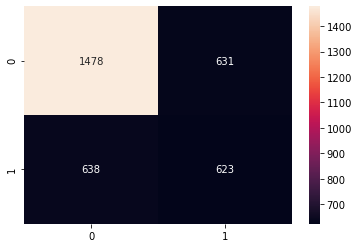

In [44]:
# Evaluación Test de EVI 

train_accuracy_score2, train_precision_score2, train_recall_score2 = calculate_binary_class_scores(y, df_evi['id'].values)

print('EVI Test Data Accuracy (%) = ', round(train_accuracy_score2*100,2))
print('EVI Test Data Precision (%) = ', round(train_precision_score2*100,2))
print('EVI Test Data Recall (%) = ', round(train_recall_score2*100,2))

cm = confusion_matrix(y, df_evi['id'].values)
print("EVI accuracy is {}%".format(((cm[0][0] + cm[1][1])/y.shape[0])*100))

sns.heatmap(cm,annot=True, fmt='g') 

In [45]:
# Realizar la clasificación Keras para todas las imágenes

list_sources = list()
list_results = list()
list_titles = list()

for img in glob.glob(os.path.join(path_sources, '*.tif')):
    imgname = os.path.basename(img)
    namepart = imgname.split('_')[0]
    imgclass = os.path.join(path_results, f"class_{namepart}-{timename}.tif")
    imgprob = os.path.join(path_results, f"prob_{namepart}-{timename}.tif")
    list_sources.append(img)
    list_results.append(imgclass)
    list_titles.append(namepart)

    newstack = Raster(img)
    [newstack.rename({name: bandsout[idx]}, in_place=True) for idx, name in enumerate(newstack.names)]
    newresult = newstack[bandsout].predict(estimator=pipeline_keras, dtype='uint8', nodata=255)
    newprob = newstack[bandsout].predict_proba(estimator=pipeline_keras)
    newresult.write(imgclass, nodata=255)
    newprob.write(imgprob, nodata=255)

588/588 [==============================] - 3s 5ms/step


In [47]:
# Generación de todas imágenes con la clasificación  Keras

for idx in range(0, len(list_results)):  
    imgname = list_titles[idx][:8]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    plt.axis('off')
    plt.suptitle(imgname, fontsize=25)
    
    with es.rio.open(list_sources[idx], 'r') as src:            
        ep.plot_rgb(src.read(), rgb=(6,3,2), ax=ax1,
                    stretch=True, extent=extent)
        manzana.boundary.plot(ax=ax1, color='white', alpha=0.5, linewidth=1)        
        ax1.axis('off')
        
    with es.rio.open(list_results[idx], 'r') as src:        
        ep.plot_bands(src.read(),  cmap='RdYlGn', ax=ax2, 
                      extent=extent, cbar=False)
        manzana.boundary.plot(ax=ax2, color='white', alpha=0.5, linewidth=1)
        ax2.axis('off')
            
    plt.tight_layout()
    plt.savefig(os.path.join(path_figures, f'rgb_{imgname}-{timename}.png'))
        
    plt.close()

In [50]:
# Generación de la animación con la secuencia imágenes con la clasificación  Keras

with imageio.get_writer(movie_classkeras, mode='I',  duration=0.8) as writer:
    for filename in sorted(glob.glob(os.path.join(path_figures, f'rgb_*-{timename}.png'))):
        print(filename)
        image = imageio.imread(filename)
        plt.tight_layout()
        writer.append_data(image)    

./tunjo/figures/rgb_20181215-20210516-213819.png
./tunjo/figures/rgb_20181225-20210516-213819.png
./tunjo/figures/rgb_20181230-20210516-213819.png
./tunjo/figures/rgb_20190213-20210516-213819.png
./tunjo/figures/rgb_20190223-20210516-213819.png
./tunjo/figures/rgb_20190325-20210516-213819.png
./tunjo/figures/rgb_20191021-20210516-213819.png
./tunjo/figures/rgb_20191205-20210516-213819.png
./tunjo/figures/rgb_20191210-20210516-213819.png
./tunjo/figures/rgb_20200104-20210516-213819.png
./tunjo/figures/rgb_20200109-20210516-213819.png
./tunjo/figures/rgb_20200114-20210516-213819.png
./tunjo/figures/rgb_20200213-20210516-213819.png
./tunjo/figures/rgb_20200329-20210516-213819.png
./tunjo/figures/rgb_20200413-20210516-213819.png
./tunjo/figures/rgb_20200428-20210516-213819.png
./tunjo/figures/rgb_20201129-20210516-213819.png
./tunjo/figures/rgb_20201204-20210516-213819.png
./tunjo/figures/rgb_20210113-20210516-213819.png
./tunjo/figures/rgb_20210309-20210516-213819.png


<Figure size 432x288 with 0 Axes>

<video controls>
  <source src="https://i.imgur.com/C1Cbu8J.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>